# Machine Learning for Stock Price Prediction
### Exercise 1.) Use some ML techniques (scikit-learn only) to predict geometric Brownian motion prices (multivariate)

In this notebook I will not only present the final solution of the exercise, but walk you through my learning process of understanding the topic of stock price prediction with the help of geometric brownian motion and the machine learning package scikit-learn.

I began by installing the Quandl package, in order to download stock price data. Unfortunately, many of the stock prices I wanted to download were behind a pay-wall and required a premium account to access, so I chose three freely available companies traded on the Frankfurt Stock Exchange, EON, Vossloh and Wacker. I began with the univariate case, where I only analysed the stock price of Wacker, which I then simulated with the help of a univariate Monte Carlo simulation.



In [ ]:
pip install quandl

I downloaded the Wacker stock prices of the month of July in 2019 and plotted them below in order to gauge the trend and volatility which are later fed into the geometric brownian motion for the Monte Carlo simulation. I chose July 2019 arbitrarily, simply for testing the model.

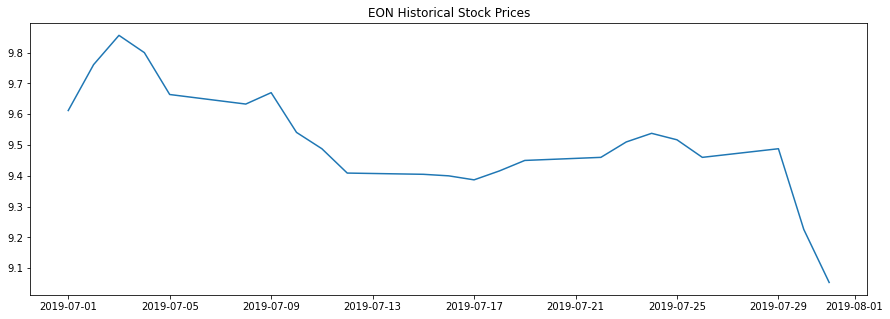

In [ ]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt

start_date_hist = '2019-07-01'
end_date_hist = '2019-07-31'
eon_historical_values = quandl.get("FSE/EON_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_hist, end_date = end_date_hist 
                ).reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(eon_historical_values['Date'], eon_historical_values['Close'])
plt.title('EON Historical Stock Prices')
plt.show()

In the next step I determined the drift and the diffusion of the stock price and implemented a univariate geometric Brownian motion of 22 time steps. 22 beign the number of trading days in the month of August 2019. I determined the drift and diffusion of EON prices in July and ran 50 simulations.

In [ ]:
# Determine the beginning and end dates of the prediction period 
start_date_pred = '2019-08-01'
end_date_pred = '2019-08-31'

# Next, we determine the number of trading days in the succeeding month
T = len(pd.bdate_range(start_date_pred, end_date_pred))
dt = 1 # Time increment (one day)
N = T/dt
t = np.arange(1, int(N) + 1) # Array of time steps

S0 = eon_historical_values['Close'][len(eon_historical_values['Close'])-1] # Final stock price of historical data and initial value for prediction 
# Next we determine the returns of the historical stock prices for each time step and derive the drift of the historical prices
returns = (eon_historical_values['Close'] - eon_historical_values['Close'].shift(1)) / eon_historical_values['Close'].shift(1)
mu = np.sum(returns[1:]) / (len(returns) - 1)

sigma = np.std(returns[1:]) # Std deviation of the returns

nr_scenarios = 50 # Number of prediction scenarios
# Now we add the random noise for future predictions
b = {str(scenario + 1): np.random.normal(0, 1, int(N)) for scenario in range(nr_scenarios)}

W = {str(scenario + 1): np.cumsum(b[str(scenario + 1)]) for scenario in range(nr_scenarios)} # Wiener Process based on random noise
drift = (mu - 0.5*sigma**2)*t
diffusion = {str(scenario + 1): sigma*W[str(scenario + 1)] for scenario in range(nr_scenarios)}

pred_dates = pd.bdate_range(start_date_pred, end_date_pred)
eon_pred_values = {str(scenario + 1): S0*np.exp(drift + diffusion[str(scenario + 1)]) for scenario in range(nr_scenarios)}







22


Below is a plot of all 50 geometric Brownian motion predictions, both alone and concatenated with the historical stock prices.



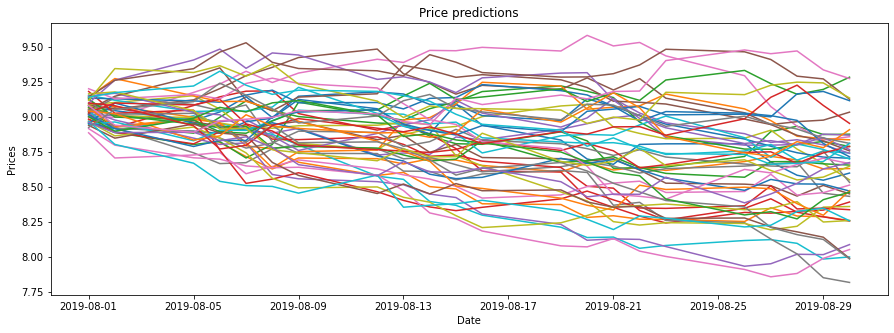

In [ ]:
plt.figure(figsize = (15, 5))
for i in range(50):
  # print(list(pred_values[str(i+1)]))
  plt.title('Price predictions')
  plt.plot(pred_dates, eon_pred_values[str(i+1)])
  
  plt.ylabel('Prices')
  plt.xlabel('Date')
plt.show()

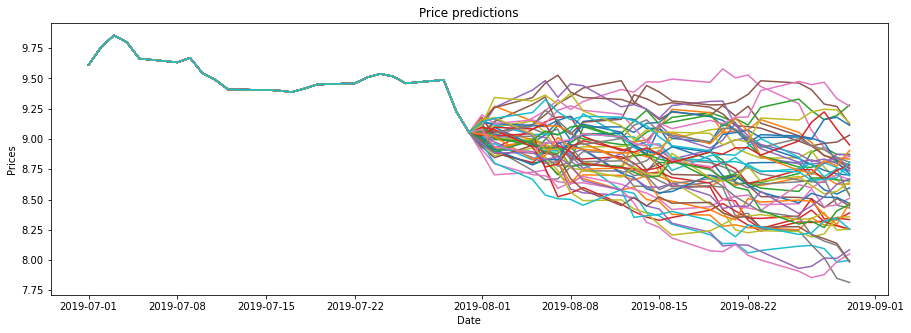

In [ ]:
dates = pd.bdate_range(start_date_hist, end_date_pred)
plt.figure(figsize = (15, 5))
for i in range(50):
  plt.title('Price predictions')
  eon_values = eon_historical_values['Close'].values.tolist() + (list(eon_pred_values[str(i+1)]))
  plt.plot(dates, eon_values)
  
  plt.ylabel('Prices')
  plt.xlabel('Date')
plt.show()

Above, we can that the simulation maintains the drift of the stock price quite nicely and the predictions look plausible.

In the next step I extrapolate the results to the multivariate case. This time I implemented a Python function for the multivariate Monte Carlo simulations and downloaded the same historical values prices I had of EON, for Vossloh and Wacker.

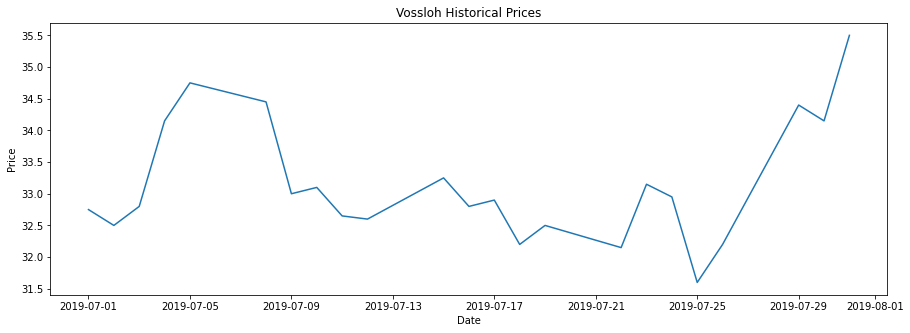

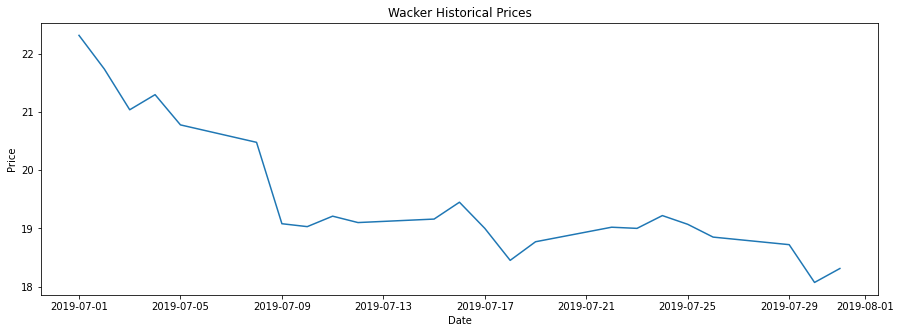

In [ ]:
vossloh_historical_values = quandl.get("FSE/VOS_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_hist, end_date = end_date_hist 
                ).reset_index(drop = False)[['Date', 'Close']]

plt.figure(figsize = (15, 5))
plt.plot(vossloh_historical_values['Date'], vossloh_historical_values['Close'])
plt.title("Vossloh Historical Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

wacker_historical_values = quandl.get("FSE/WAC_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_hist, end_date = end_date_hist 
                ).reset_index(drop = False)[['Date', 'Close']]

plt.figure(figsize = (15, 5))
plt.plot(wacker_historical_values['Date'], wacker_historical_values['Close'])
plt.title("Wacker Historical Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()



Given this data I now determine the correlation of the three different stocks and applied the Coletzky Facorisation to the correlation matrix.

In [ ]:
EON_historical_values = eon_historical_values.rename(columns = {'Close':'EON'})
Wacker_historical_values = wacker_historical_values.rename(columns = {'Close':'Wacker'})
Vossloh_historical_values = vossloh_historical_values.rename(columns = {'Close':'Vossloh'})

collective_hist_prices = pd.concat([EON_historical_values, Vossloh_historical_values['Vossloh'], Wacker_historical_values['Wacker']], axis=1)

corr_matrix = collective_hist_prices.corr(method='pearson')


Below is a function for the simulation of correlated multivariate geometric brownian motions, which I tested on a set of made-up stock prices. I imagined three different correlated stochastic processes with different drifts, diffusions, initial values and an arbitrarily chosen correlation matrix.

In [ ]:
def MultivariatePrediction(S0, mu, sig, corr_matrix, steps, nr_scenarios):
  drift = mu - (sig**2 / 2)
  choldec_corr = np.linalg.cholesky(corr_matrix)
  pred_values = {str(scenario + 1): None for scenario in range(nr_scenarios)}
  for scenario in range(nr_scenarios):
    x = np.random.standard_normal(size = (steps, 3))
    eps = np.matmul(x, choldec_corr)
    pred_values[str(scenario + 1)] = np.matmul(np.cumprod(np.exp(np.tile(np.array(drift), (steps, 1)) + np.matmul(eps, np.diagflat(sig))), 0),np.diagflat(S0))
  return pred_values

example = MultivariatePrediction(np.array([[1,4,8]]), np.array([[0.01,0.01,0.01]]), np.array([[0.01,0.01,0.01]]), np.array([[1,0,0], [0,1,0], [0,0,1]]),100,1000)

Below are the plots of the simulated multivariate geometric Brownian motions with start values 1,4 and 8, respective expected values (of returns) and standard deviations of 0.001, which I assumed to be completely uncorrelated. I ran 1000 simulation of 100 time steps each.

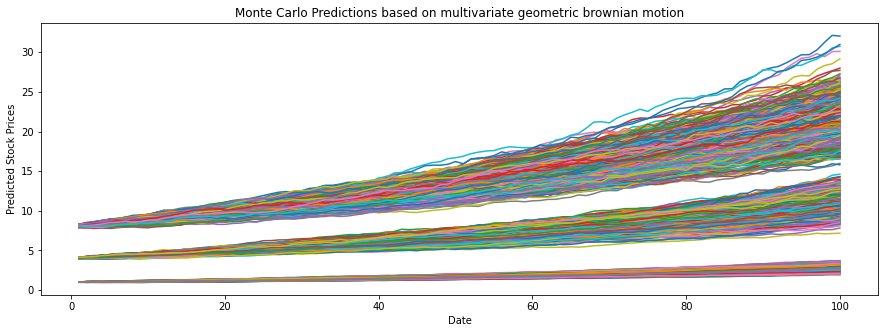

In [ ]:
plt.figure(figsize = (15, 5))
for i in range(len(example)):
  plt.plot(range(1, 101), example[str(i+1)])
plt.title('Monte Carlo Predictions based on multivariate geometric brownian motion')
plt.xlabel('Date')
plt.ylabel('Predicted Stock Prices')
plt.show()

In the graph above we can see that there are three distinct graphs, each with a steady, 1% increase per time step. The reason the uppermost graph has the steepest incline is due to it having the largest initial value.

Next, I apply the multivariate geometric Brownian motion to the data on the stock prices of EON, Vossloh and Wacker I obtained earlier. I determine the initial values, which are given by the respective stock prices on 31.07.2019. I determine the number of prediction steps by the number of trading days in the month of August, 2019. Next, I deteremine the drift and diffusion of the three respetive stocks, as well as their correlation, to which I then apply the cholesky factorisation. I plug all of these values into my function, called "MultivariatePrediction" and plot the values below.

I also determined the average of all geometric Brownian motion simulations at each time step, which are seen in the plots below. These values will serve as my test data in the later LSTM model.


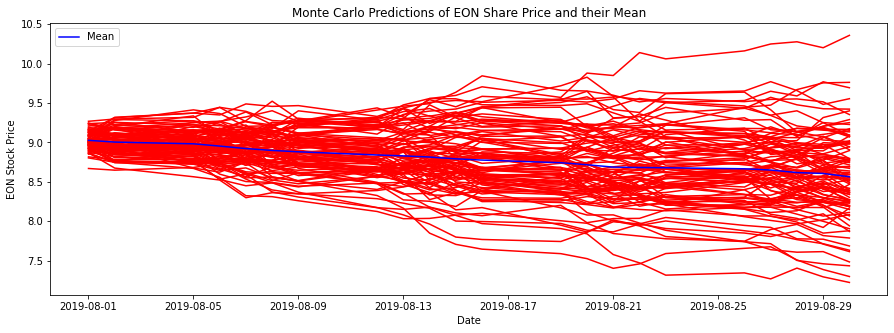

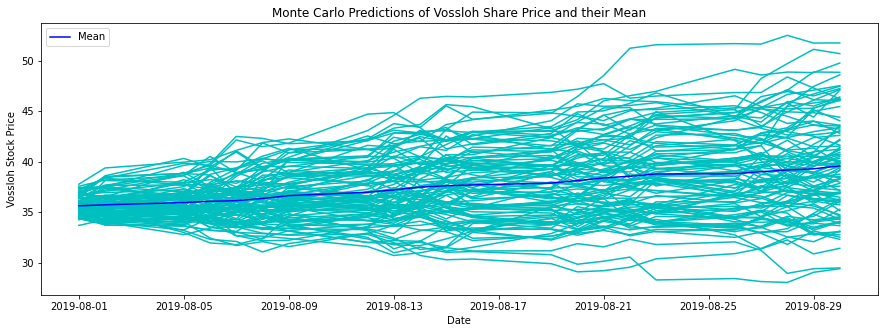

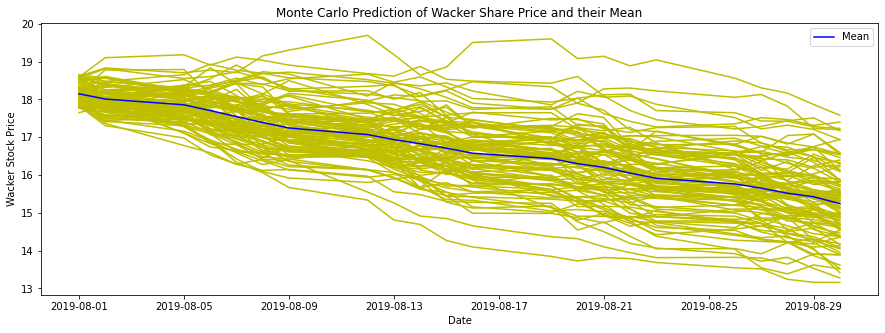

In [ ]:

#MultivariatePrediction(S0, mu, sig, corr_matrix, steps, nr_scenarios)
import matplotlib.patches as mpatches


S0 = [collective_hist_prices['EON'][22], collective_hist_prices['Vossloh'][22], collective_hist_prices['Wacker'][22]]#, collective_hist_prices['Zooplus'][22]]
mu = {'EON': None, 'Vossloh': None, 'Wacker': None}#, 'Vossloh': None}
sig = {'EON': None, 'Vossloh': None, 'Wacker': None}#, 'Vossloh': None}
steps = len(pd.bdate_range(start_date_pred, end_date_pred))
nr_scenarios = 100
pred_dates = pd.bdate_range(start_date_pred, end_date_pred)

for name in ['EON', 'Vossloh', 'Wacker']:#, 'Vossloh']:
  returns = (collective_hist_prices[name] - collective_hist_prices[name].shift(1)) / collective_hist_prices[name].shift(1)
  mu[name] = np.sum(returns[1:]) / (len(returns) - 1)
  sig[name] = np.std(returns[1:])


multivariate_pred_values = MultivariatePrediction(S0, np.array(list(mu.values())), np.array(list(sig.values())), corr_matrix, steps, nr_scenarios)
tr_multivariate_pred_values = {str(i+1): np.transpose(multivariate_pred_values[str(i+1)]) for i in range(nr_scenarios)}

mean_pred_values = {'Date': None, 'EON': None, 'Vossloh': None, 'Wacker': None}
mean_pred_values['Date'] = pred_dates
mean_pred_values['EON'] = [np.mean([tr_multivariate_pred_values[str(n)][0][j] for n in range(1, 100)]) for j in range(steps)]
mean_pred_values['Vossloh'] = [np.mean([tr_multivariate_pred_values[str(n)][1][j] for n in range(1, 100)]) for j in range(steps)]
mean_pred_values['Wacker'] = [np.mean([tr_multivariate_pred_values[str(n)][2][j] for n in range(1, 100)]) for j in range(steps)]


plt.figure(figsize = (15, 5))

company_names = ['EON', 'Vossloh', 'Wacker']

for i in range(len(tr_multivariate_pred_values)):
  plt.plot(pred_dates, tr_multivariate_pred_values[str(i+1)][0], 'r')
plt.plot(pred_dates, mean_pred_values['EON'], 'b', label='Mean')
plt.title('Monte Carlo Predictions of EON Share Price and their Mean')
plt.xlabel('Date')
plt.ylabel('EON Stock Price')
plt.legend()
plt.show()
plt.figure(figsize = (15, 5))
for i in range(len(tr_multivariate_pred_values)):
  plt.plot(pred_dates, tr_multivariate_pred_values[str(i+1)][1], 'c')
plt.plot(pred_dates, mean_pred_values['Vossloh'], 'b', label='Mean')
plt.title('Monte Carlo Predictions of Vossloh Share Price and their Mean')
plt.xlabel('Date')
plt.ylabel('Vossloh Stock Price')
plt.legend()
plt.show()
plt.figure(figsize = (15, 5))
for i in range(len(tr_multivariate_pred_values)):
  plt.plot(pred_dates, tr_multivariate_pred_values[str(i+1)][2], 'y')
plt.plot(pred_dates, mean_pred_values['Wacker'], 'b', label='Mean')
plt.title('Monte Carlo Prediction of Wacker Share Price and their Mean')
plt.xlabel('Date')
plt.ylabel('Wacker Stock Price')
plt.legend()
plt.show()




In the plots above we can see that the Monte Carlo simulation maintains the repsective trends of the stock prices reasonably well and the simulations seem to have a reasonable curve as well.

Next, we concatenate these plots with the historical data on the stock prices, in order to be able to visually gauge their accuracy better.

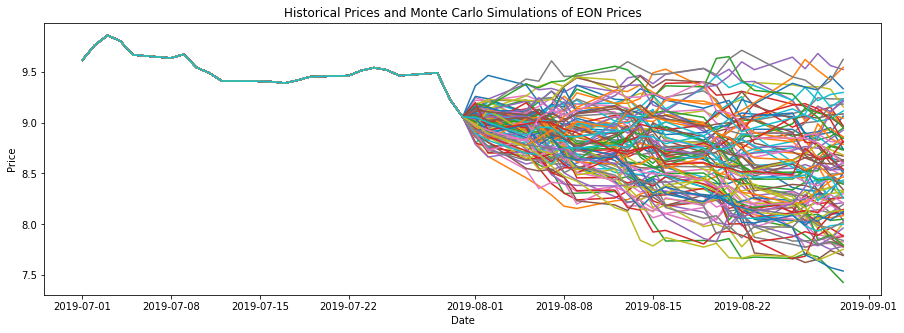

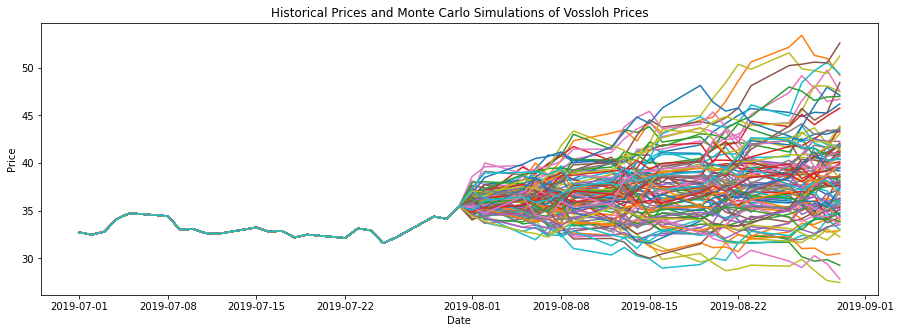

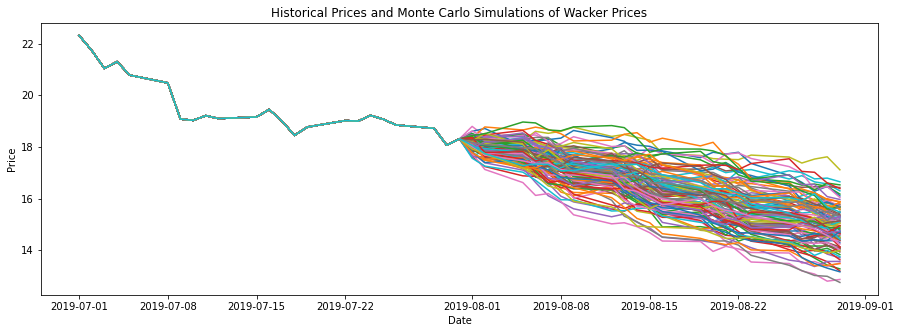

In [ ]:
start_date_hist = '2019-07-01'
end_date_pred = '2019-08-31'
dates = pd.bdate_range(start_date_hist, end_date_pred)


plt.figure(figsize = (15, 5))
for i in range(nr_scenarios):
  plt.plot(dates, collective_hist_prices['EON'].values.tolist() + list(tr_multivariate_pred_values[str(i+1)][0]))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Prices and Monte Carlo Simulations of EON Prices')
plt.show()

plt.figure(figsize = (15, 5))
for i in range(nr_scenarios):
  plt.plot(dates, collective_hist_prices['Vossloh'].values.tolist() + list(tr_multivariate_pred_values[str(i+1)][1]))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Prices and Monte Carlo Simulations of Vossloh Prices')
plt.show()

plt.figure(figsize = (15, 5))
for i in range(nr_scenarios):
  plt.plot(dates, collective_hist_prices['Wacker'].values.tolist() + list(tr_multivariate_pred_values[str(i+1)][2]))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Prices and Monte Carlo Simulations of Wacker Prices')
plt.show()


In the plots above we can see that the multivariate geomtric Brownian motion does a good job of predicting the stock prices, maintaining their respetive trends and diffusions reasonably well. 

In the next step I utilise the historical stock prices and the results of the Monte Carlo simulations to train a machine learning algorithm. The method I chose for forecasting is an LSTM model.

###LSTM
The Long Short Term Memory model is a popular machine learning technique for time series forecasting, based on a recurring neural network. The reason LSTM is so effective at time-series predictions is that it has a built-in memory, allowing it to base predictions on past values, making it very effective at learning long-term dependencies in data.

An LSTM network has 4 network layers, a cell state, three gates which provide it with the power to selectively learn, unlearn or retain information from each of the units. Each unit has an input, output and a forget gate which can add or remove the information to the cell state. The forget gate decides which information from the previous cell state should be forgotten for which it uses a sigmoid function. The input gate controls the information flow to the current cell state using a point-wise multiplication operation of ‘sigmoid’ and ‘tanh’ respectively. Finally, the output gate decides which information should be passed on to the next hidden state.


I implemented an LSTM neural network with a look back of 10 time steps, a bathc size of 7 and 100 epochs. The reason I chose these values was simply due to the accuracy of their output and the fact that the size of the training set must be divisible by the batch size. 

I 'fed' the network a pandas dataframe containing values of the means of the mean of all Monte Carlo simulations performed. For testing I downloaded values from the month of September, 2019.

In [ ]:
df_mean_pred_values = pd.DataFrame(mean_pred_values)

from keras.preprocessing import sequence
from keras.models import load_model

timesteps = len(pd.bdate_range('2019-09-01', '2019-09-30'))

from sklearn.preprocessing import MinMaxScaler

training_set_scaled = {'Date': mean_pred_values['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled['EON'] = sc.fit_transform(df_mean_pred_values.iloc[:,1:2].values)
training_set_scaled['Vossloh'] = sc.fit_transform(df_mean_pred_values.iloc[:,2:3].values)
training_set_scaled['Wacker'] = sc.fit_transform(df_mean_pred_values.iloc[:,3:4].values)


X_train = {'Date': mean_pred_values['Date'], 'EON': [], 'Vossloh': [], 'Wacker': []}
y_train = {'Date': mean_pred_values['Date'], 'EON': [], 'Vossloh': [], 'Wacker': []}
"""for i in range(10, 21):#7
    X_train['EON'].append(training_set_scaled['EON'][i-10:i, 0])#7
    y_train['EON'].append(training_set_scaled['EON'][i, 0])

    X_train['Vossloh'].append(training_set_scaled['Vossloh'][i-10:i, 0])#7
    y_train['Vossloh'].append(training_set_scaled['Vossloh'][i, 0])

    X_train['Wacker'].append(training_set_scaled['Wacker'][i-10:i, 0])#7
    y_train['Wacker'].append(training_set_scaled['Wacker'][i, 0])"""

for i in range(21-2):#7
    X_train['EON'].append(training_set_scaled['EON'][i:(i+1), 0])#7
    y_train['EON'].append(training_set_scaled['EON'][i+1, 0])

    X_train['Vossloh'].append(training_set_scaled['Vossloh'][i:(i+1), 0])#7
    y_train['Vossloh'].append(training_set_scaled['Vossloh'][i+1, 0])

    X_train['Wacker'].append(training_set_scaled['Wacker'][i:(i+1), 0])#7
    y_train['Wacker'].append(training_set_scaled['Wacker'][i+1, 0])


X_train['EON'], y_train['EON'] = np.array(X_train['EON']), np.array(y_train['EON'])
X_train['Vossloh'], y_train['Vossloh'] = np.array(X_train['Vossloh']), np.array(y_train['Vossloh'])
X_train['Wacker'], y_train['Wacker'] = np.array(X_train['Wacker']), np.array(y_train['Wacker'])


X_train['EON'] = np.reshape(X_train['EON'], (X_train['EON'].shape[0], X_train['EON'].shape[1], 1))
X_train['Vossloh'] = np.reshape(X_train['Vossloh'], (X_train['Vossloh'].shape[0], X_train['Vossloh'].shape[1], 1))
X_train['Wacker'] = np.reshape(X_train['Wacker'], (X_train['Wacker'].shape[0], X_train['Wacker'].shape[1], 1))


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train['EON'].shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train['EON'], y_train['EON'], epochs = 100, batch_size = 1) #7 (11)




regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train['Vossloh'].shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train['Vossloh'], y_train['Vossloh'], epochs = 100, batch_size = 1) #7 (11)




regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train['Wacker'].shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train['Wacker'], y_train['Wacker'], epochs = 100, batch_size = 1) #7 (11)




Using TensorFlow backend.


Epoch 1/100
19/19 [==============================] - 3s 174ms/step - loss: 0.2738
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2092
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1289
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0615
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0505
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0458
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0483
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0340
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0261
Epoch 10/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 11/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0226
Epoch 12/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 13/100
19/19 [===============

In [ ]:
start_date_pred = '2019-09-01'
end_date_pred = '2019-09-30'
test_data = {'Date': pd.bdate_range(start_date_pred, end_date_pred), 'EON': None, 'Vossloh': None, 'Wacker': None}

test_data['EON'] = quandl.get("FSE/EON_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_pred, end_date = end_date_pred 
                ).reset_index(drop = False)[['Date', 'Close']]

test_data['Vossloh'] = quandl.get("FSE/VOS_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_pred, end_date = end_date_pred 
                ).reset_index(drop = False)[['Date', 'Close']]

test_data['Wacker'] = quandl.get("FSE/WAC_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_pred, end_date = end_date_pred
                ).reset_index(drop = False)[['Date', 'Close']]

df_test_data = {'Date': pd.bdate_range(start_date_pred, end_date_pred), 'EON': None, 'Vossloh':None, 'Wacker': None}
df_test_data['EON'] = pd.DataFrame(test_data['EON'])
df_test_data['Vossloh'] = pd.DataFrame(test_data['Vossloh'])
df_test_data['Wacker'] = pd.DataFrame(test_data['Wacker'])

pred_values_total = {'Date': pd.bdate_range(start_date_pred, end_date_pred), 'EON': None, 'Vossloh': None, 'Wacker': None}
pred_values_total['EON'] = pd.concat((df_mean_pred_values['EON'], df_test_data['EON']['Close']), axis = 0)
pred_values_total['Vossloh'] = pd.concat((df_mean_pred_values['Vossloh'], df_test_data['Vossloh']['Close']), axis = 0)
pred_values_total['Wacker'] = pd.concat((df_mean_pred_values['Wacker'], df_test_data['Wacker']['Close']), axis = 0)

inputs = {'Date': pd.bdate_range(start_date_pred, end_date_pred), 'EON': None, 'Vossloh':None, 'Wacker': None}
"""inputs['EON'] = pred_values_total['EON'][len(pred_values_total) - len(df_test_data['EON']) - 10:].values #7
inputs['Vossloh'] = pred_values_total['Vossloh'][len(pred_values_total) - len(df_test_data['Vossloh']) - 10:].values #7
inputs['Wacker'] = pred_values_total['Wacker'][len(pred_values_total) - len(df_test_data['Wacker']) - 10:].values #7"""
inputs['EON'] = pred_values_total['EON'].values#[len(pred_values_total) - len(df_test_data['EON']) - 10:].values
inputs['Vossloh'] = pred_values_total['Vossloh'].values#[len(pred_values_total) - len(df_test_data['Vossloh']) - 10:].values
inputs['Wacker'] = pred_values_total['Wacker'].values#[len(pred_values_total) - len(df_test_data['Wacker']) - 10:].values


inputs['EON'] = inputs['EON'].reshape(-1,1)
inputs['EON'] = sc.transform(inputs['EON'])

inputs['Vossloh'] = inputs['Vossloh'].reshape(-1,1)
inputs['Vossloh'] = sc.transform(inputs['Vossloh'])

inputs['Wacker'] = inputs['Wacker'].reshape(-1,1)
inputs['Wacker'] = sc.transform(inputs['Wacker'])

X_test = {'Date': pd.bdate_range(start_date_pred, end_date_pred), 'EON': [], 'Vossloh': [], 'Wacker': []}

"""for i in range(10, 22): #7
    X_test['EON'].append(inputs['EON'][i-10:i, 0]) #7
    X_test['Vossloh'].append(inputs['Vossloh'][i-10:i, 0]) #7
    X_test['Wacker'].append(inputs['Wacker'][i-10:i, 0]) #7"""

for i in range(22-2):
    X_test['EON'].append(inputs['EON'][i:(i+1), 0]) 
    X_test['Vossloh'].append(inputs['Vossloh'][i:(i+1), 0]) 
    X_test['Wacker'].append(inputs['Wacker'][i:(i+1), 0])


X_test['EON'] = np.array(X_test['EON'])
X_test['Vossloh'] = np.array(X_test['Vossloh'])
X_test['Wacker'] = np.array(X_test['Wacker'])

X_test['EON'] = np.reshape(X_test['EON'], (X_test['EON'].shape[0], X_test['EON'].shape[1], 1))
X_test['Vossloh'] = np.reshape(X_test['Vossloh'], (X_test['Vossloh'].shape[0], X_test['Vossloh'].shape[1], 1))
X_test['Wacker'] = np.reshape(X_test['Wacker'], (X_test['Wacker'].shape[0], X_test['Wacker'].shape[1], 1))

predicted_stock_prices = {'Date': pd.bdate_range(start_date_pred, end_date_pred), 'EON': None, 'Vossloh': None, 'Wacker': None}

predicted_stock_prices['EON'] = regressor.predict(X_test['EON'])
predicted_stock_prices['EON'] = sc.inverse_transform(predicted_stock_prices['EON'])

predicted_stock_prices['Vossloh'] = regressor.predict(X_test['Vossloh'])
predicted_stock_prices['Vossloh'] = sc.inverse_transform(predicted_stock_prices['Vossloh'])

predicted_stock_prices['Wacker'] = regressor.predict(X_test['Wacker'])
predicted_stock_prices['Wacker'] = sc.inverse_transform(predicted_stock_prices['Wacker'])

# print(predicted_stock_prices)

Next, I plot the results and compare them to the actual values of the stock prices in the month of September 2019. As a measure of accuracy I use the mean square error. 

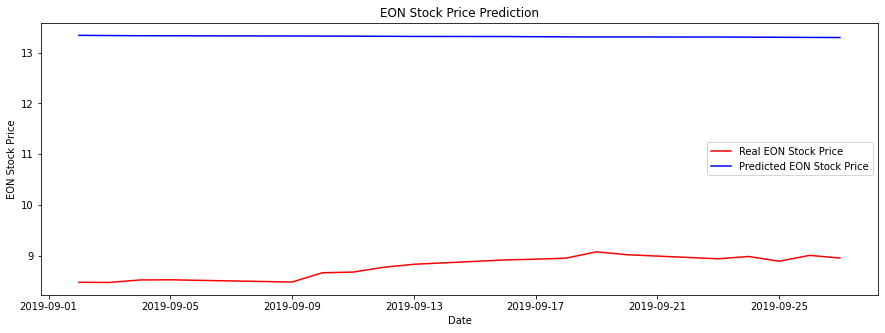

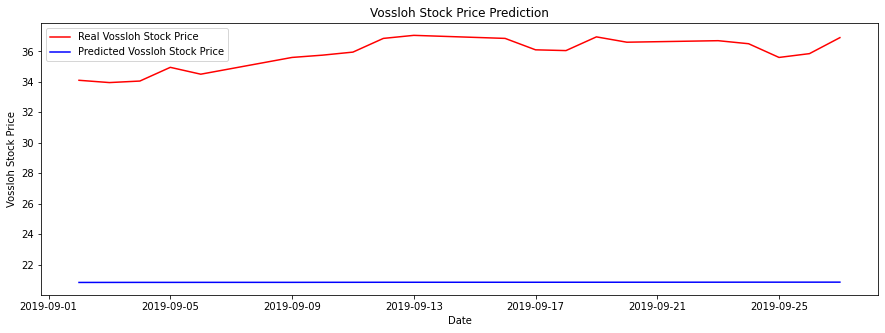

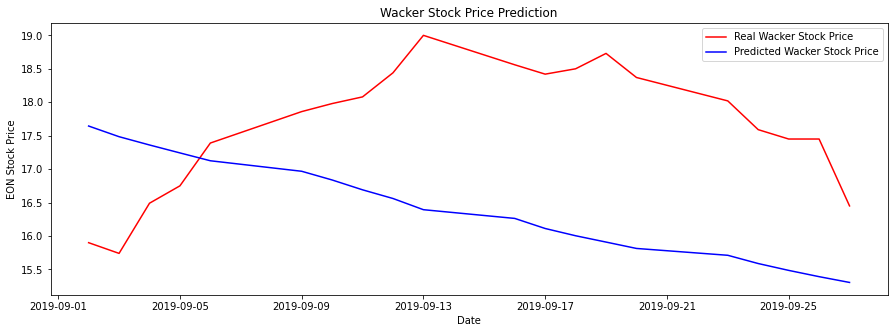

In [ ]:
plt.figure(figsize = (15, 5))
"""plt.plot(test_data['EON']['Date'][0:12], test_data['EON']['Close'][0:12], color = 'red', label = 'Real EON Stock Price')
plt.plot(test_data['EON']['Date'][0:12], predicted_stock_prices['EON'], color = 'blue', label = 'Predicted EON Stock Price')"""
plt.plot(test_data['EON']['Date'][0:20], test_data['EON']['Close'][0:20], color = 'red', label = 'Real EON Stock Price')
plt.plot(test_data['EON']['Date'][0:20], predicted_stock_prices['EON'], color = 'blue', label = 'Predicted EON Stock Price')
plt.title('EON Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('EON Stock Price')
plt.legend()
plt.show()

plt.figure(figsize = (15, 5))
"""plt.plot(test_data['Vossloh']['Date'][0:12], test_data['Vossloh']['Close'][0:12], color = 'red', label = 'Real Vossloh Stock Price')
plt.plot(test_data['Vossloh']['Date'][0:12], predicted_stock_prices['Vossloh'], color = 'blue', label = 'Predicted Vossloh Stock Price')"""
plt.plot(test_data['Vossloh']['Date'][0:20], test_data['Vossloh']['Close'][0:20], color = 'red', label = 'Real Vossloh Stock Price')
plt.plot(test_data['Vossloh']['Date'][0:20], predicted_stock_prices['Vossloh'], color = 'blue', label = 'Predicted Vossloh Stock Price')
plt.title('Vossloh Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Vossloh Stock Price')
plt.legend()
plt.show()

plt.figure(figsize = (15, 5))
"""plt.plot(test_data['Wacker']['Date'][0:12], test_data['Wacker']['Close'][0:12], color = 'red', label = 'Real Wacker Stock Price')
plt.plot(test_data['Wacker']['Date'][0:12], predicted_stock_prices['Wacker'], color = 'blue', label = 'Predicted Wacker Stock Price')"""
plt.plot(test_data['Wacker']['Date'][0:20], test_data['Wacker']['Close'][0:20], color = 'red', label = 'Real Wacker Stock Price')
plt.plot(test_data['Wacker']['Date'][0:20], predicted_stock_prices['Wacker'], color = 'blue', label = 'Predicted Wacker Stock Price')
plt.title('Wacker Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('EON Stock Price')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error
EON_error = mean_squared_error(test_data['EON']['Close'][0:20], predicted_stock_prices['EON'])
Vossloh_error = mean_squared_error(test_data['Vossloh']['Close'][0:20], predicted_stock_prices['Vossloh'])
Wacker_error = mean_squared_error(test_data['Wacker']['Close'][0:20], predicted_stock_prices['Wacker'])

print(EON_error)
print(Vossloh_error)
print(Wacker_error)


20.636489512332837
226.11028396405965
3.5791138844734443


The predictions displayed and the respective mean square errors are extremely inacucrate. I found several explanations for this.


1.   Scarce data:
I chose an extremely short period of the stock price data to train the neural network with. This is bound to lead to inaccurate results, as the algorithm has limited data to extract important information from. As one can see in the example of the EON predictions, the output of the algorithm is approximately a straight line. The model has failed to learn much about the volatility of the stock price from the historical data. Hence, we may find ourselves facing an instance of overfitting.
2.   Wrong interval for prediction values
I've realised that I have chosen the wrong time period for the prediction values. Given my lookback of 7 time steps, the period I should have chosen to display the predicted time series, should have been [10.08.2019, 10.09.2019]. Regardless of the time frame the predicted values are completely inaccurate. 

In the step, I adjust the time frame of historical data I used as training data, as well as the time frame for the geometric Brownian motion predictions used as testing data. I changed the training interval to [01.01.2019, 31.12.2019] and the interval for the Monte Carlo simulation to [01.01.2020, 15.06.2020]. I also changed the lookback to a time step of 1, as I found out that this dramatically improves accuracy. 

Below is the Monte Carlo simulation of six months.



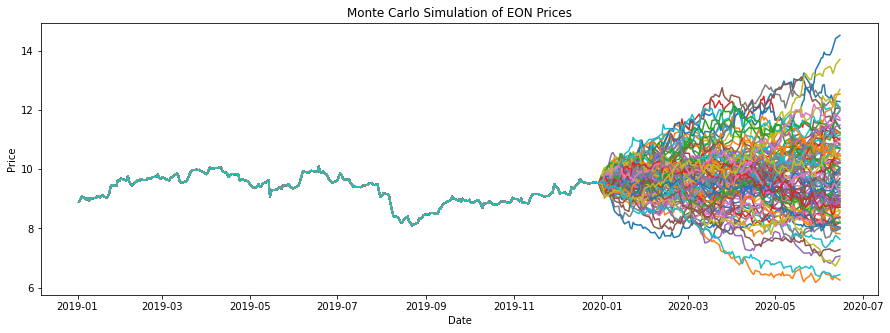

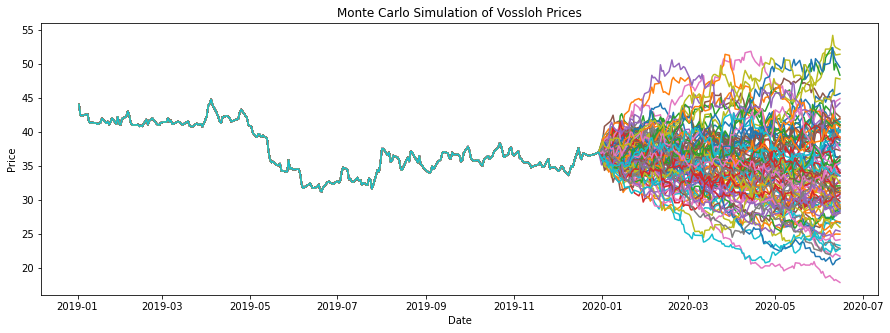

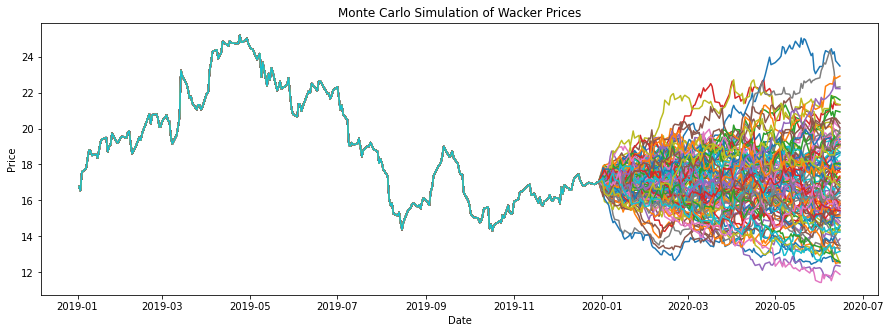

In [ ]:
start_date_hist = '2019-01-01'
end_date_hist = '2019-12-31'
start_date_pred = '2020-01-01'
end_date_pred = '2020-06-15'

eon_historical_values = quandl.get("FSE/EON_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_hist, end_date = end_date_hist 
                ).reset_index(drop = False)[['Date', 'Close']]

vossloh_historical_values = quandl.get("FSE/VOS_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_hist, end_date = end_date_hist 
                ).reset_index(drop = False)[['Date', 'Close']]

wacker_historical_values = quandl.get("FSE/WAC_X", 
                authtoken="skymJWsxi8M9v1Do8EHs", 
                start_date = start_date_hist, end_date = end_date_hist 
                ).reset_index(drop = False)[['Date', 'Close']]


EON_historical_values = eon_historical_values.rename(columns = {'Close':'EON'})
Wacker_historical_values = wacker_historical_values.rename(columns = {'Close':'Wacker'})
Vossloh_historical_values = vossloh_historical_values.rename(columns = {'Close':'Vossloh'})

collective_hist_prices = pd.concat([EON_historical_values, Vossloh_historical_values['Vossloh'], Wacker_historical_values['Wacker']], axis=1)

"""
print("Number Quandl Dates: ", len(collective_hist_prices['Date']))
print("Number Actual Dates: ", len(pd.bdate_range(start_date_hist, end_date_hist)))
print("Historical Dates: ", pd.DataFrame(pd.bdate_range(start_date_hist, end_date_hist)))
print("Quandl Dates: ", collective_hist_prices['Date'])
"""

S0 = [collective_hist_prices['EON'][249], collective_hist_prices['Vossloh'][249], collective_hist_prices['Wacker'][249]]#, collective_hist_prices['Zooplus'][22]]
mu = {'EON': None, 'Vossloh': None, 'Wacker': None}
sig = {'EON': None, 'Vossloh': None, 'Wacker': None}
steps = len(pd.bdate_range(start_date_pred, end_date_pred))
nr_scenarios = 100
pred_dates = pd.bdate_range(start_date_pred, end_date_pred)

for name in ['EON', 'Vossloh', 'Wacker']:
  returns = (collective_hist_prices[name] - collective_hist_prices[name].shift(1)) / collective_hist_prices[name].shift(1)
  mu[name] = np.sum(returns[1:]) / (len(returns) - 1)
  sig[name] = np.std(returns[1:])


multivariate_pred_values = MultivariatePrediction(S0, np.array(list(mu.values())), np.array(list(sig.values())), corr_matrix, steps, nr_scenarios)
tr_multivariate_pred_values = {str(i+1): np.transpose(multivariate_pred_values[str(i+1)]) for i in range(nr_scenarios)}

mean_pred_values = {'Date': None, 'EON': None, 'Vossloh': None, 'Wacker': None}
mean_pred_values['Date'] = pred_dates
mean_pred_values['EON'] = [np.mean([tr_multivariate_pred_values[str(n)][0][j] for n in range(1, 100)]) for j in range(steps)]
mean_pred_values['Vossloh'] = [np.mean([tr_multivariate_pred_values[str(n)][1][j] for n in range(1, 100)]) for j in range(steps)]
mean_pred_values['Wacker'] = [np.mean([tr_multivariate_pred_values[str(n)][2][j] for n in range(1, 100)]) for j in range(steps)]

#dates = pd.bdate_range(start_date_hist, end_date_pred)
#dates = pd.DataFrame(dates).drop(114) #Quandl for some reason does not give me data for the 10.06.2019
#dates = pd.DataFrame(eon_historical_values['Date'].values.tolist() + mean_pred_values['Date'].values.tolist())
dates = pd.concat([eon_historical_values['Date'], pd.DataFrame(mean_pred_values['Date'][:])])

plt.figure(figsize = (15, 5))
for i in range(nr_scenarios):
  plt.plot(dates, collective_hist_prices['EON'].values.tolist() + list(tr_multivariate_pred_values[str(i+1)][0]))
plt.title('Monte Carlo Simulation of EON Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.figure(figsize = (15, 5))
for i in range(nr_scenarios):
  plt.plot(dates, collective_hist_prices['Vossloh'].values.tolist() + list(tr_multivariate_pred_values[str(i+1)][1]))
plt.title('Monte Carlo Simulation of Vossloh Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.figure(figsize = (15, 5))
for i in range(nr_scenarios):
  plt.plot(dates, collective_hist_prices['Wacker'].values.tolist() + list(tr_multivariate_pred_values[str(i+1)][2]))
plt.title('Monte Carlo Simulation of Wacker Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Now I impemlement the LSTM model with a batch size of 1, a lookback of 1 and 100 epochs.

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        #b = np.array([dataset[i + look_back, 0]])
        #dataY.append(b)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
from keras.preprocessing import sequence
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

mean_pred_values = pd.DataFrame(mean_pred_values)

data = {'Date': dates.values.tolist(), 'EON': None, 'Vossloh':None, 'Wacker': None}
data['EON'] = pd.concat((pd.DataFrame(collective_hist_prices['EON']), pd.DataFrame(mean_pred_values['EON'])), axis=0)['EON'].values#.tolist()
data['Vossloh'] = pd.concat((pd.DataFrame(collective_hist_prices['Vossloh']), pd.DataFrame(mean_pred_values['Vossloh'])), axis=0)['Vossloh'].values#.tolist()
data['Wacker'] = pd.concat((pd.DataFrame(collective_hist_prices['Wacker']), pd.DataFrame(mean_pred_values['Wacker'])), axis=0)['Wacker'].values#.tolist()
data = pd.DataFrame(data)

sc = MinMaxScaler(feature_range = (0, 1))
scaled_data = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
scaled_data['EON'] = sc.fit_transform(data.iloc[:,1:2].values)
scaled_data['Vossloh'] = sc.fit_transform(data.iloc[:,2:3].values)
scaled_data['Wacker'] = sc.fit_transform(data.iloc[:,3:4].values)

train_data = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
test_data = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
train_data['EON'], test_data['EON'] = scaled_data['EON'][0:249,:], scaled_data['EON'][249:369,:]
train_data['Vossloh'], test_data['Vossloh'] = scaled_data['Vossloh'][0:249,:], scaled_data['Vossloh'][249:369,:]
train_data['Wacker'], test_data['Wacker'] = scaled_data['Wacker'][0:249,:], scaled_data['Wacker'][249:369,:]

look_back = 1

trainX = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
trainY = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
testX = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
testY = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}

trainX['EON'], trainY['EON'] = create_dataset(train_data['EON'], look_back)
testX['EON'], testY['EON'] = create_dataset(test_data['EON'], look_back)

trainX['EON'] = np.reshape(trainX['EON'], (trainX['EON'].shape[0], 1, trainX['EON'].shape[1]))
testX['EON'] = np.reshape(testX['EON'], (testX['EON'].shape[0], 1, testX['EON'].shape[1]))


trainX['Vossloh'], trainY['Vossloh'] = create_dataset(train_data['Vossloh'], look_back)
testX['Vossloh'], testY['Vossloh'] = create_dataset(test_data['Vossloh'], look_back)

trainX['Vossloh'] = np.reshape(trainX['Vossloh'], (trainX['Vossloh'].shape[0], 1, trainX['Vossloh'].shape[1]))
testX['Vossloh'] = np.reshape(testX['Vossloh'], (testX['Vossloh'].shape[0], 1, testX['Vossloh'].shape[1]))



trainX['Wacker'], trainY['Wacker'] = create_dataset(train_data['Wacker'], look_back)
testX['Wacker'], testY['Wacker'] = create_dataset(test_data['Wacker'], look_back)

trainX['Wacker'] = np.reshape(trainX['Wacker'], (trainX['Wacker'].shape[0], 1, trainX['Wacker'].shape[1]))
testX['Wacker'] = np.reshape(testX['Wacker'], (testX['Wacker'].shape[0], 1, testX['Wacker'].shape[1]))


trainpredict = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}
testpredict = {'Date': data['Date'], 'EON': None, 'Vossloh': None, 'Wacker': None}

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX['EON'], trainY['EON'], epochs=100, batch_size=1, verbose=2)

trainpredict['EON'] = model.predict(trainX['EON'])
testpredict['EON'] = model.predict(testX['EON'])
trainpredict['EON'] = sc.inverse_transform(trainpredict['EON'])
trainY['EON'] = sc.inverse_transform([trainY['EON']])
testpredict['EON'] = sc.inverse_transform(testpredict['EON'])
testY['EON'] = sc.inverse_transform([testY['EON']])



model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX['Vossloh'], trainY['Vossloh'], epochs=100, batch_size=1, verbose=2)

trainpredict['Vossloh'] = model.predict(trainX['Vossloh'])
testpredict['Vossloh'] = model.predict(testX['Vossloh'])
trainpredict['Vossloh'] = sc.inverse_transform(trainpredict['Vossloh'])
trainY['Vossloh'] = sc.inverse_transform([trainY['Vossloh']])
testpredict['Vossloh'] = sc.inverse_transform(testpredict['Vossloh'])
testY['Vossloh'] = sc.inverse_transform([testY['Vossloh']])




model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX['Wacker'], trainY['Wacker'], epochs=100, batch_size=1, verbose=2)

trainpredict['Wacker'] = model.predict(trainX['Wacker'])
testpredict['Wacker'] = model.predict(testX['Wacker'])
trainpredict['Wacker'] = sc.inverse_transform(trainpredict['Wacker'])
trainY['Wacker'] = sc.inverse_transform([trainY['Wacker']])
testpredict['Wacker'] = sc.inverse_transform(testpredict['Wacker'])
testY['Wacker'] = sc.inverse_transform([testY['Wacker']])



Epoch 1/100
 - 1s - loss: 0.0964
Epoch 2/100
 - 0s - loss: 0.0125
Epoch 3/100
 - 0s - loss: 0.0093
Epoch 4/100
 - 0s - loss: 0.0069
Epoch 5/100
 - 0s - loss: 0.0050
Epoch 6/100
 - 0s - loss: 0.0037
Epoch 7/100
 - 0s - loss: 0.0030
Epoch 8/100
 - 0s - loss: 0.0026
Epoch 9/100
 - 0s - loss: 0.0026
Epoch 10/100
 - 0s - loss: 0.0026
Epoch 11/100
 - 0s - loss: 0.0025
Epoch 12/100
 - 0s - loss: 0.0025
Epoch 13/100
 - 0s - loss: 0.0025
Epoch 14/100
 - 0s - loss: 0.0025
Epoch 15/100
 - 0s - loss: 0.0025
Epoch 16/100
 - 0s - loss: 0.0025
Epoch 17/100
 - 0s - loss: 0.0025
Epoch 18/100
 - 0s - loss: 0.0026
Epoch 19/100
 - 0s - loss: 0.0025
Epoch 20/100
 - 0s - loss: 0.0025
Epoch 21/100
 - 0s - loss: 0.0024
Epoch 22/100
 - 0s - loss: 0.0025
Epoch 23/100
 - 0s - loss: 0.0025
Epoch 24/100
 - 0s - loss: 0.0025
Epoch 25/100
 - 0s - loss: 0.0024
Epoch 26/100
 - 0s - loss: 0.0024
Epoch 27/100
 - 0s - loss: 0.0025
Epoch 28/100
 - 0s - loss: 0.0025
Epoch 29/100
 - 0s - loss: 0.0024
Epoch 30/100
 - 0s - lo

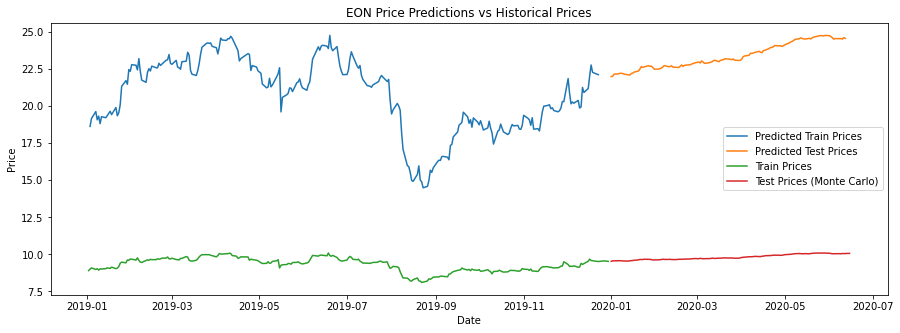

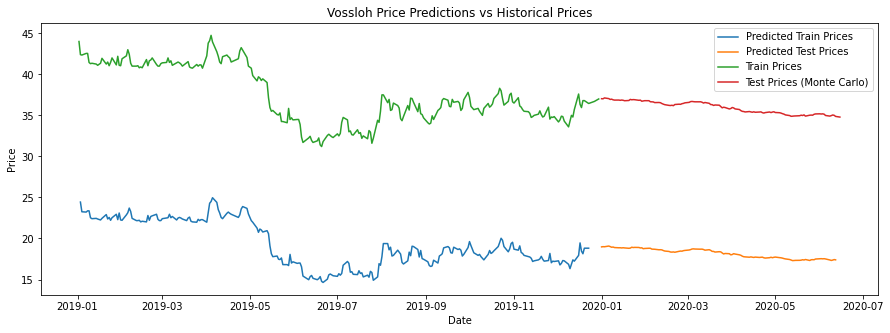

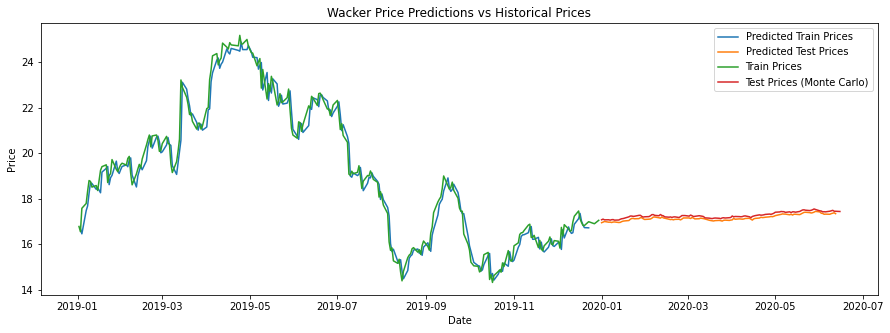

In [ ]:
plt.figure(figsize = (15, 5))
plt.title('EON Price Predictions vs Historical Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(dates[1:len(trainpredict['EON'])+1], trainpredict['EON'], label='Predicted Train Prices')
plt.plot(pred_dates[:-1], testpredict['EON'], label='Predicted Test Prices')
plt.plot(collective_hist_prices['Date'], collective_hist_prices['EON'], label='Train Prices')
plt.plot(mean_pred_values['Date'], mean_pred_values['EON'], label='Test Prices (Monte Carlo)')
plt.legend()
plt.show()


plt.figure(figsize = (15, 5))
plt.title('Vossloh Price Predictions vs Historical Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(dates[1:len(trainpredict['Vossloh'])+1], trainpredict['Vossloh'], label='Predicted Train Prices')
plt.plot(pred_dates[:-1], testpredict['Vossloh'], label='Predicted Test Prices')
plt.plot(collective_hist_prices['Date'], collective_hist_prices['Vossloh'], label='Train Prices')
plt.plot(mean_pred_values['Date'], mean_pred_values['Vossloh'], label='Test Prices (Monte Carlo)')
plt.legend()
plt.show()


plt.figure(figsize = (15, 5))
plt.title('Wacker Price Predictions vs Historical Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(dates[1:len(trainpredict['Wacker'])+1], trainpredict['Wacker'], label='Predicted Train Prices')
plt.plot(pred_dates[:-1], testpredict['Wacker'], label='Predicted Test Prices')
plt.plot(collective_hist_prices['Date'], collective_hist_prices['Wacker'], label='Train Prices')
plt.plot(mean_pred_values['Date'], mean_pred_values['Wacker'], label='Test Prices (Monte Carlo)')
plt.legend()
plt.show()

We can see in the plots above that the accuracy of the predictions has improved dramatically. In particular, the stock prices of Wacker are very accurate. The stock prices of EON and Vossloh are very good at predicting the trend and standard deviation of the stock prices, however they are shifted and seem to squashed. This is an error that still nededs to be fixed, but I cannot seem to identify its origin. 

#Question 2

#How should we use explainable AI to better understand reinforcement learning?

##Explainable AI
Explainable AI (XAI) refers to methods and techniques that make the results of artificial intelligence applications understandable to humans. It contrasts with the concept of the "black box" in machine learning where even the developers cannot explain why an algorithm produces a certain result. XAI is an implementation of the social right to explanation. Humans should be able to "audit" the rules produced by an AI in order to spot erroneous results that do not generalise beyond the test data, such as spurious correlations, over-/underfitting and class imbalance, etc. It is required by the european GDPR under the name of "the right to explainability".

Modern complex AI techniques, such as deep learning and genetic algorithms are naturally opaque. To address this issue, there has been a development of many new methods to make new models more explainable and interpretable.

This includes many methods, such as Layerwise relevance propagation (LRP), a technique for determining which features in a particular input vector contribute most strongly to a neural network's output. Other techniques have been developed to explain one particular prediction made by a (nonlinear) black-box model, a goal referred to as "local interpretability". In addition, there has been work on decision trees and Bayesian networks, which are more transparent to inspection. In 2018 an interdisciplinary conference called FAT* (Fairness, Accountability, and Transparency) was established to study transparency and explainability in the context of socio-technical systems, many of which include artificial intelligence.
##Reinforcement Learning
Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning. 

Reinforcement learning, due to its generality, is studied in many other disciplines, such as game theory, control theory, operations research, information theory, simulation-based optimisation, multi-agent systems, swarm intelligence, statistics and genetic algorithms. The problem with reinforcement learning is its opaqueness and the fact that explainability in reinforcement learning is hardly explored [1].

Basic reinforcement is modeled as a Markov decision process:

* a set of environment and agent states, S;
* a set of actions, A, of the agent;
* ${\displaystyle \mathbb{P}_{a}(s,s')=\mathbb{P}(s_{t+1}=s'\mid s_{t}=s,a_{t}=a)}$ is the probability of transition (at time $t$) from state $s$ to state $s′$ under action $a$;
* $R_a(s,s')$ is the immediate reward after transition from $s$ to $s′$ with action $a$;
* rules that describe what the agent observes


The agent's action selection is modeled as a map called policy:

$π : A × S → [ 0 , 1 ]$

$π ( a , s ) = \mathbb{P}( a_t = a ∣ s_t = s )$ 

The policy map gives the probability of taking action $a$ when in state $s$.
Every state is assigned a particular value through a value function  $V_\pi( s )$, which is defined as the expected return starting with state $s$ and successively following policy $\pi$,

$V_\pi(s)=\mathbb{E}[R] = \mathbb{E}[\sum\limits_{t=0}^{\infty}\gamma^tr_t | s_0=s].$

It is the goal of the reinforcement algorithm to find a policy taht maximises the return.
##Making Reinforcement Learning Explainable
In my research I have discovered three methods to make reinforcement learning techniques more explainablein three different papers.

1.) Explainable Reinforcement Learning through a Causal Lens [1].

2.) Hierarchical and Interpretable Skill Acquisition in Multi-task Reinforcement Learning [2].

3.) Distal Explanations for Explainable Reinforcement Learning Agents [3].
###1.) Hierarchical skill acquisition in multi-task reinforcement learning [1]
Shu et al. extend multi-task reinforcement learning to a two-layer hierarchical structure to achieve modularity and divide complex tasks into smaller subtasks. The authors trained a reinforcement algorithm to perform tasks in the computer game MineCraft. 

The algorithm is supposed to lean how to locate a box of particular colour, pick it up and place it on top of another box of a particular colour. The authors use the advantage actor-critic (A2C) for policy optimisation. Every top-level policy can be decomposed into low-level actions, which is why the model is called hierarchical. Increasing the granularity of the tasks assigned to the learner increases the explainability of the algorithm, as each low-level task is given by human instruction. 

Additionally, they incorporated a stochastic temporal grammar method to order subtasks temporally. If a learner knew how to perform all subtasks, no new learning was required. If not, it will have to learn at least one of the new subtasks.



##2.) Explainable Reinforcement Learning through a Causal Lens [2]
Madumal et al. base their research in making reinforcement learning explainable on the observation that in order to understand or interpret a phenomenon, humans build causal models to encode the cause-effect mapping of events happening around us. The authors try to build a structural causal model for generating causal explanations of the behaviour of model-free reinforcement learning agents through variables of interest.
The authors also investigate the comprehension gained by the users through the explanations, and explanation satisfaction of the users, as well as trust induced in the user for model-free reinforcement learning agents. 

They extend structural causal models by incorporating action influence models on markov decision processes based reinforcement learning. A structural causal model is given by a signature $S=(U,V,R)$ and a set of structural equations $F$. Here, $U$ is the set of exogeneous variables and $V$ is the set of engoenous variables, and $R$ is a function determining the range of all variables $Y\in{}U\cup{}V$. $F$ contains functions $F_X$ for every $X\in{}V$, such that $F_X$ gives the value of $X$ based on other variables in $U\cup{}V$. A structural causal model (SCM) is then given by the tuple $M=(S,F)$. Lastly, define a context $\mathbb{u}$ as a vector of unique values for every exogenous variable in $U$. A situation is then the pair $(M,\mathbb{u})$. 

An action influence model is a tupel $(S_a,F)$, where $S_a$ is a signature, as given above, extended by a set of actions $\mathcal{A}$. The set of structural equations now contains functions $F_{X,a}$ that depend not only on the random variable $X$, but also on the action $a$.

The authors manage to generate explanations from this model by defining the action influence model, learning the structural equations during reinforcement learning, and generating explanations. In their paper they mostly focus on answering questions of the types: "Why choose action $a$ and not $b$?". They generate two types of explanations, complete explanations and minimally complete explanations. 

##3.) Distal Explanations for Explainable Reinforcement Learning Agents [3]
In the case of 2.) the authors acknowledge that structural equations perform poorly, and offer another approach in [3], namely to substitute these with decision nodes from a decision tree. While training the reinforcement learner, the authors implement "experience replay", by storing $e_t=(s_t,a_t)$ at each learning stage $t$ into a dataset $D_t$, which is randomly sampled to train the decision tree $\mathbb{T}$.

Now given an action $a$ from the decision tree, minimally complete explanations can be given by a set of reward variables, and intermediate variables in the tree. Analogously, for minimally complete contrastive explanations, i.e. answers to the question "why not choose action a?".








###Bibliography 
[1] Shu, Tianmin, Caiming Xiong, and Richard Socher. "Hierarchical and interpretable skill acquisition in multi-task reinforcement learning." arXiv preprint arXiv:1712.07294 (2017)
[2] Madumal, Prashan, et al. "Explainable reinforcement learning through a causal lens." arXiv preprint arXiv:1905.10958 (2019)
[3] Madumal, Prashan, et al. “Distal Explanations for Explainable Reinforcement Learning Agents.” arXiv preprint arXiv:2001.10284 (2020).












